In [1]:
import polars as pl
import numpy as np
import pandas as pd
from scipy import signal
import io
from scipy import ndimage
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os

### Main functions


In [ ]:
def robust_iqr_normalization(df):
    normalized_df = pd.DataFrame()
    
    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # First quartile (Q1)
        Q3 = df[column].quantile(0.75)  # Third quartile (Q3)
        IQR = Q3 - Q1  # Interquartile range (IQR)
        
        # Normalize the data
        normalized_df[column] = (df[column] - Q1) / IQR
        
    return normalized_df

In [ ]:
###Inverval filteration and hrv feature generation
import hrvanalysis as hrv
import scipy.signal as signal
def bbi_filter(beat_interval):
    #remove outliers
    print("inital length")

    filtered_interval = hrv.remove_outliers(beat_interval,low_rri = 400,high_rri = 1200)
    #Replace na values with linear interpolation using forier transfer
    interpolated_interval = hrv.interpolate_nan_values(filtered_interval,interpolation_method="linear")
    # This remove ectopic beats from signal
    nn_intervals_list = hrv.remove_ectopic_beats(interpolated_interval, method="malik")
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = hrv.interpolate_nan_values(nn_intervals_list)
    # nn_intervals =  hrv.get_nn_intervals(interpolated_interval)
    return interpolated_nn_intervals

def hrv_generation(peak_intervals,orign_df,rr_itv,binsize=120, mechano_acoustic = True):
    """ This function takes a peak peak interval list, bin size in second,a boolean, and the original dataset with time stamps as input, then will remove the abnormal intervals and heart beats and generate the HRV features.  """
   
    if mechano_acoustic:
        ma_df = orign_df
        
        itv_1 = 0
        itv_2 = 0
        i = 0
        k = 0
        hr = pd.DataFrame(columns=['index','Hr'])
        ma_it = pd.DataFrame(columns=['index','Hr'])
        hrv_feature = pd.DataFrame()
        while i < len(peak_intervals)-1:
            
            interval = peak_intervals[i]
            # itv_1 = peaks[i+2]
            i = i+1
            itv_2 = itv_2 + rr_itv[i]
            itv_1 = interval+itv_1
            k=k+interval
            hr_df = pd.DataFrame({'index': itv_2,'Hr':interval},index = [itv_2])
            hr = pd.concat([hr,hr_df])
            ma_it = pd.concat([ma_it,hr_df])
            if k > binsize*1000:
                bined_interval = hr.Hr.values.tolist()
                feature = pd.DataFrame([hrv.get_frequency_domain_features(bined_interval)])
                feature = pd.merge_asof(feature,pd.DataFrame([hrv.get_time_domain_features(bined_interval)]),left_index=True,right_index=True)
                feature = pd. merge_asof(feature,pd.DataFrame([hrv.get_geometrical_features(bined_interval)]),left_index=True,right_index=True)
                feature = pd. merge_asof(feature,pd.DataFrame([hrv.get_csi_cvi_features(bined_interval)]),left_index=True,right_index=True)
                # try:
                #     feature = pd.DataFrame([hrv.get_frequency_domain_features(bined_interval)])
                # except:
                #     print('feature error')
                # itv_1 = int(itv_1)
                itv_2 = int(itv_2)
                feature['time'] = ma_df.index[itv_2]
                hrv_feature = pd.concat([hrv_feature,feature],ignore_index=True)
                hr = pd.DataFrame(columns=['index','Hr'])
                k=0 
            
        ma_hrv = hrv_feature.copy()
        ##return ma_hrv, ma_it
        return ma_hrv,ma_it
    
def shannon_energy(x):
    x_env = -x**2 * np.log(x**2)
    return(x_env)

# def bandpass_filt(sig,cutoff,fs,mode):
#     nyq = 0.5*fs
#     wn = cutoff/nyq
#     sos = signal.butter(4, wn, btype=mode,output='sos')
#     return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=sig.columns,index=sig.index)
def bandpass_filt(sig,cutoff,fs,mode):
    nyq = 0.5*fs
    wn = cutoff/nyq
    sos = signal.butter(4, wn, btype=mode,output='sos')
    if isinstance(sig,pd.DataFrame):
        # if you gave in a dataframe, get it back with the appropriate columns
        return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=sig.columns,index=sig.index)
    elif isinstance(sig,pd.Series):
        return pd.DataFrame(data=signal.sosfiltfilt(sos,sig,axis=0),columns=[sig.name],index=sig.index)
    else:
        return signal.sosfiltfilt(sos,sig,axis=0)
#generate cwt matrix
def do_cwt(csv):
    fs = 1e-09**-1/np.median(np.diff(csv.index.values.astype(np.int64)))
    csv = pd.DataFrame(csv)
    test_bp = bandpass_filt(csv,(20,51),fs,'bandpass')
    test_bp = test_bp.to_numpy().flatten()
    cwtmtx = signal.cwt(test_bp,signal.morlet,np.arange(1,15))
    # tm = pd.to_datetime(csv.index)

    ## find cwt local maxiums 
    # cwt_pk = cwtmtx.T[:,1:15]
    cwt_pk = cwtmtx.T
    cwt_pks = cwt_pk.max(axis=1)


    #use shannon energy to process oscaliating signal
    cwt_se = shannon_energy(cwt_pks)
    cwt_se_gs = ndimage.gaussian_filter(np.abs(cwt_se),sigma=25)#40 is taken from the average heart sound lobe of 100ms 0.1*fs/4

    
    return cwt_se_gs

inital length
0 outlier(s) have been deleted.
13489 ectopic beat(s) have been deleted with malik rule.


C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()
C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()


inital length
0 outlier(s) have been deleted.
8836 ectopic beat(s) have been deleted with malik rule.


C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()
C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()


inital length
1 outlier(s) have been deleted.
The outlier(s) value(s) are : [1279]
12383 ectopic beat(s) have been deleted with malik rule.


C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()
C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()


inital length
8 outlier(s) have been deleted.
The outlier(s) value(s) are : [1259, 1231, 1212, 1279, 1252, 1220, 1214, 1285]
11452 ectopic beat(s) have been deleted with malik rule.


C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()
C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()


inital length
4 outlier(s) have been deleted.
The outlier(s) value(s) are : [1251, 1220, 1201, 1207]
12066 ectopic beat(s) have been deleted with malik rule.


C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()
C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()


inital length
0 outlier(s) have been deleted.
7596 ectopic beat(s) have been deleted with malik rule.


C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()
C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()


inital length
0 outlier(s) have been deleted.
4106 ectopic beat(s) have been deleted with malik rule.


C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()
C:\Users\13103\AppData\Local\Temp\ipykernel_5956\263726171.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()


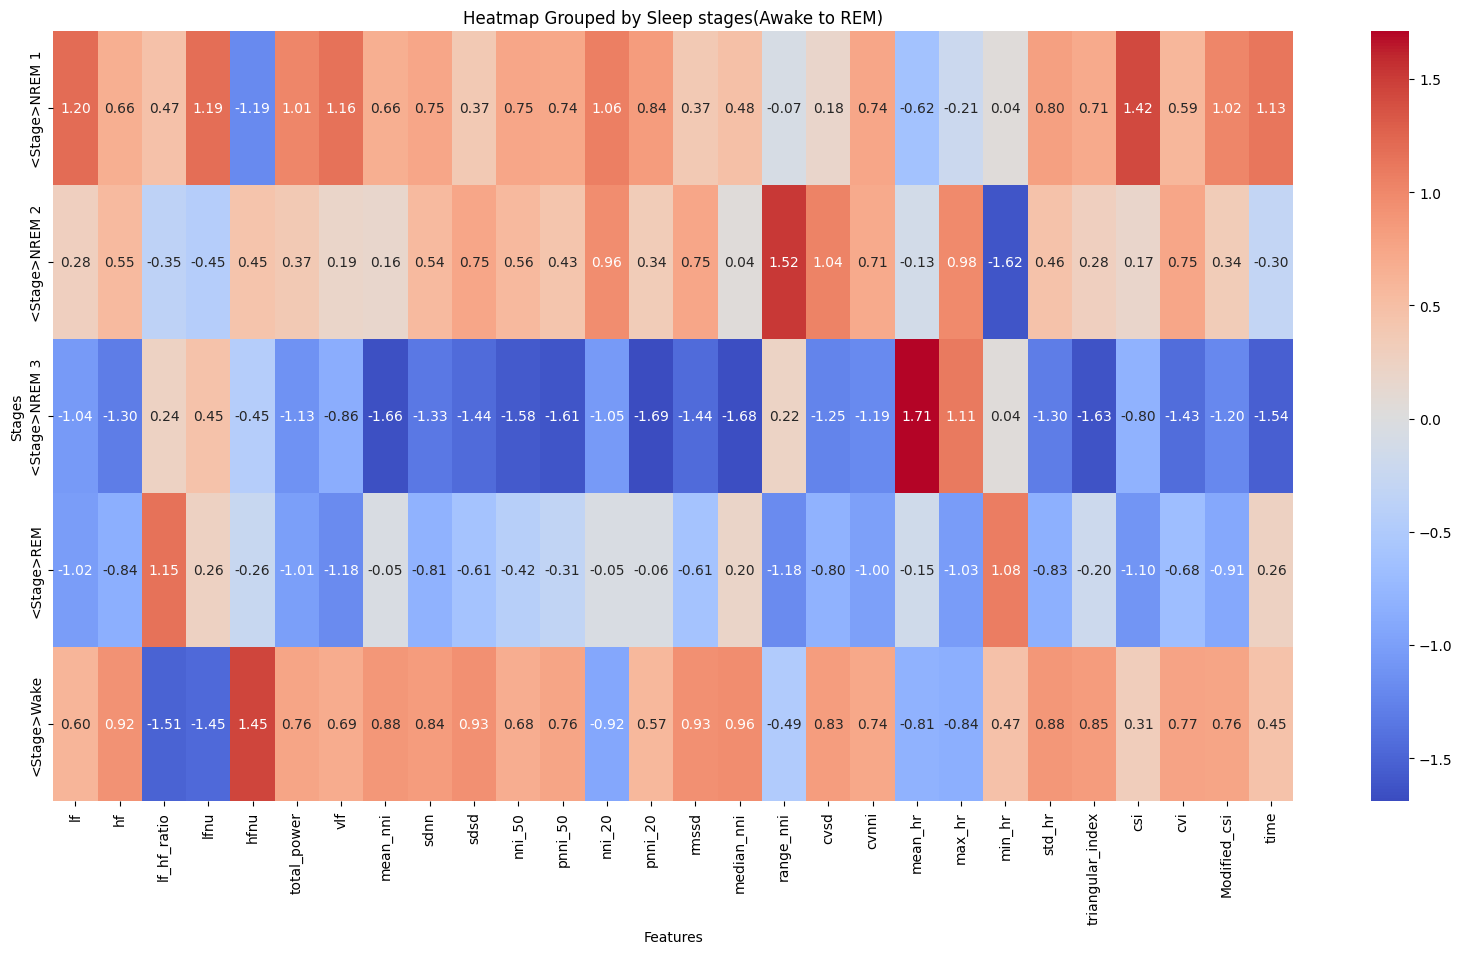

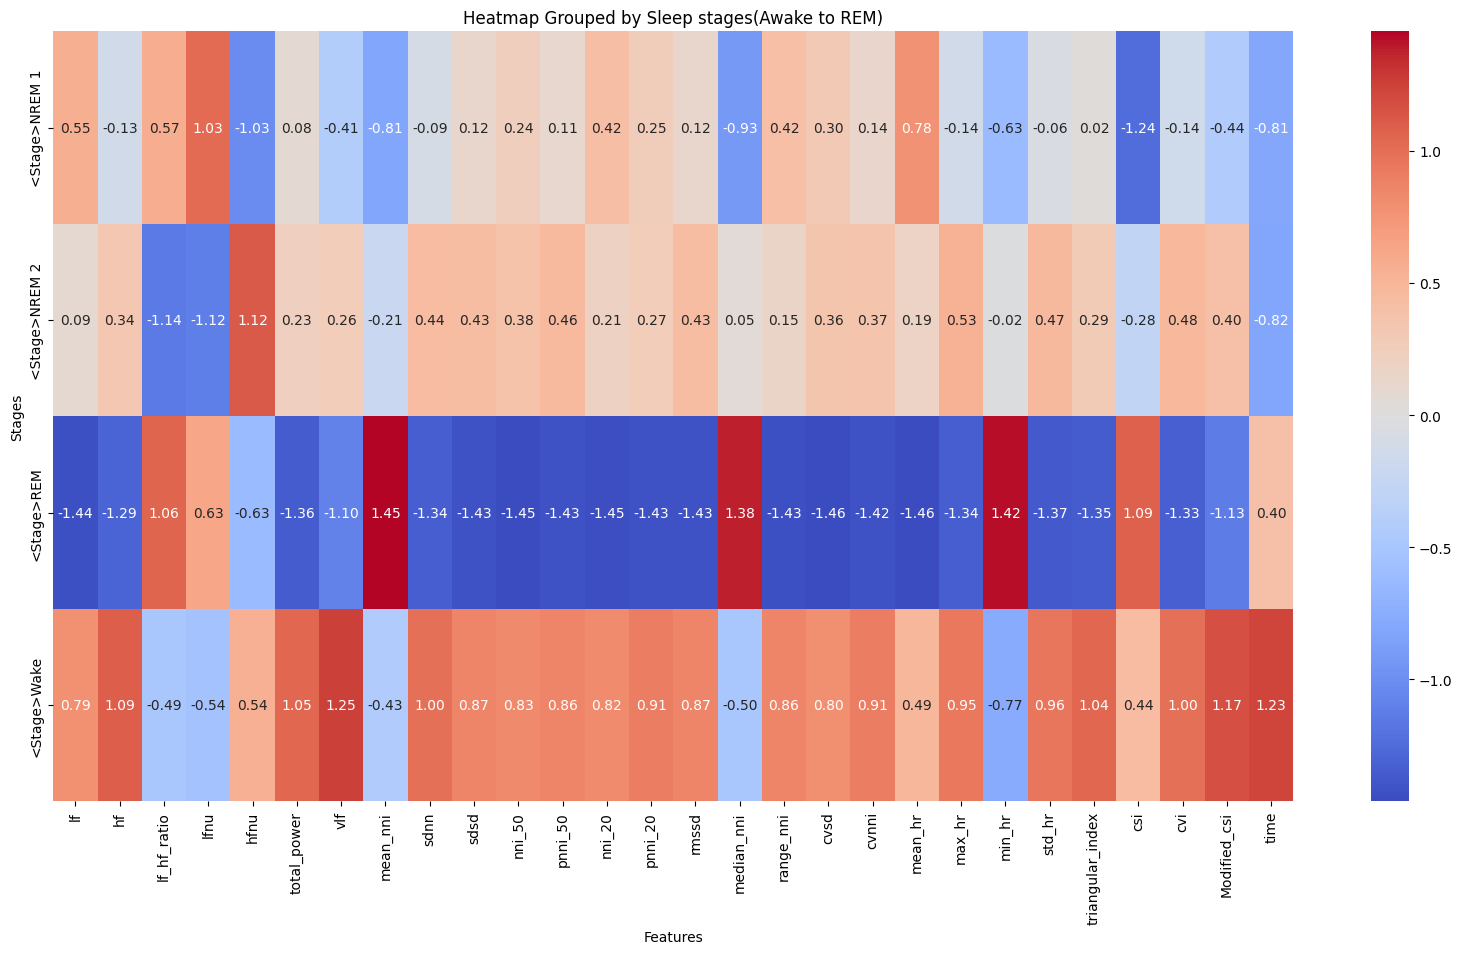

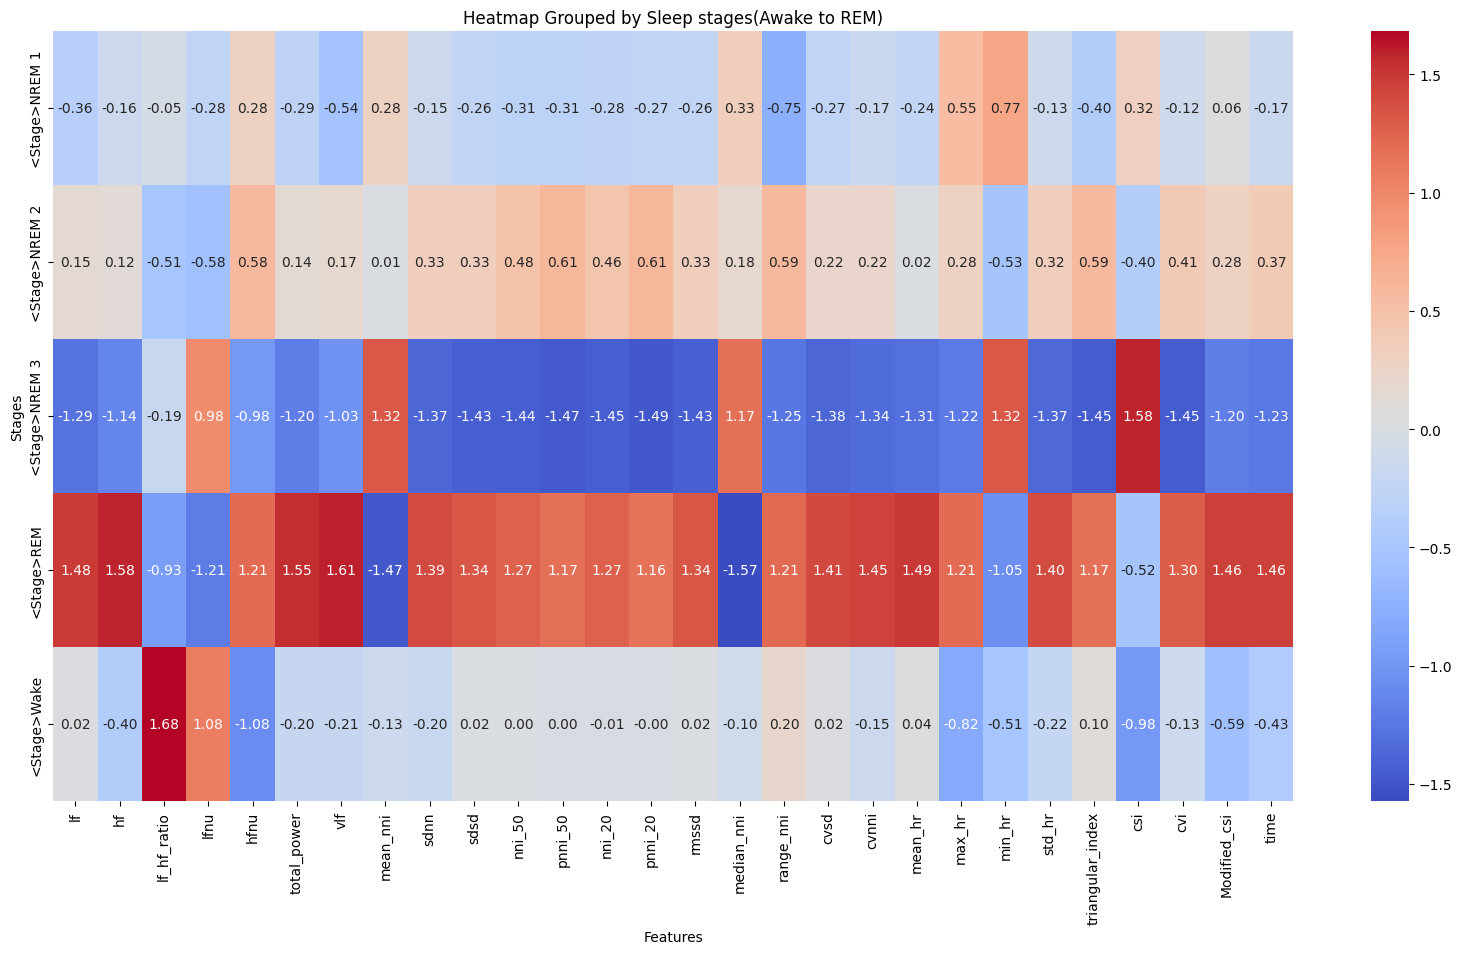

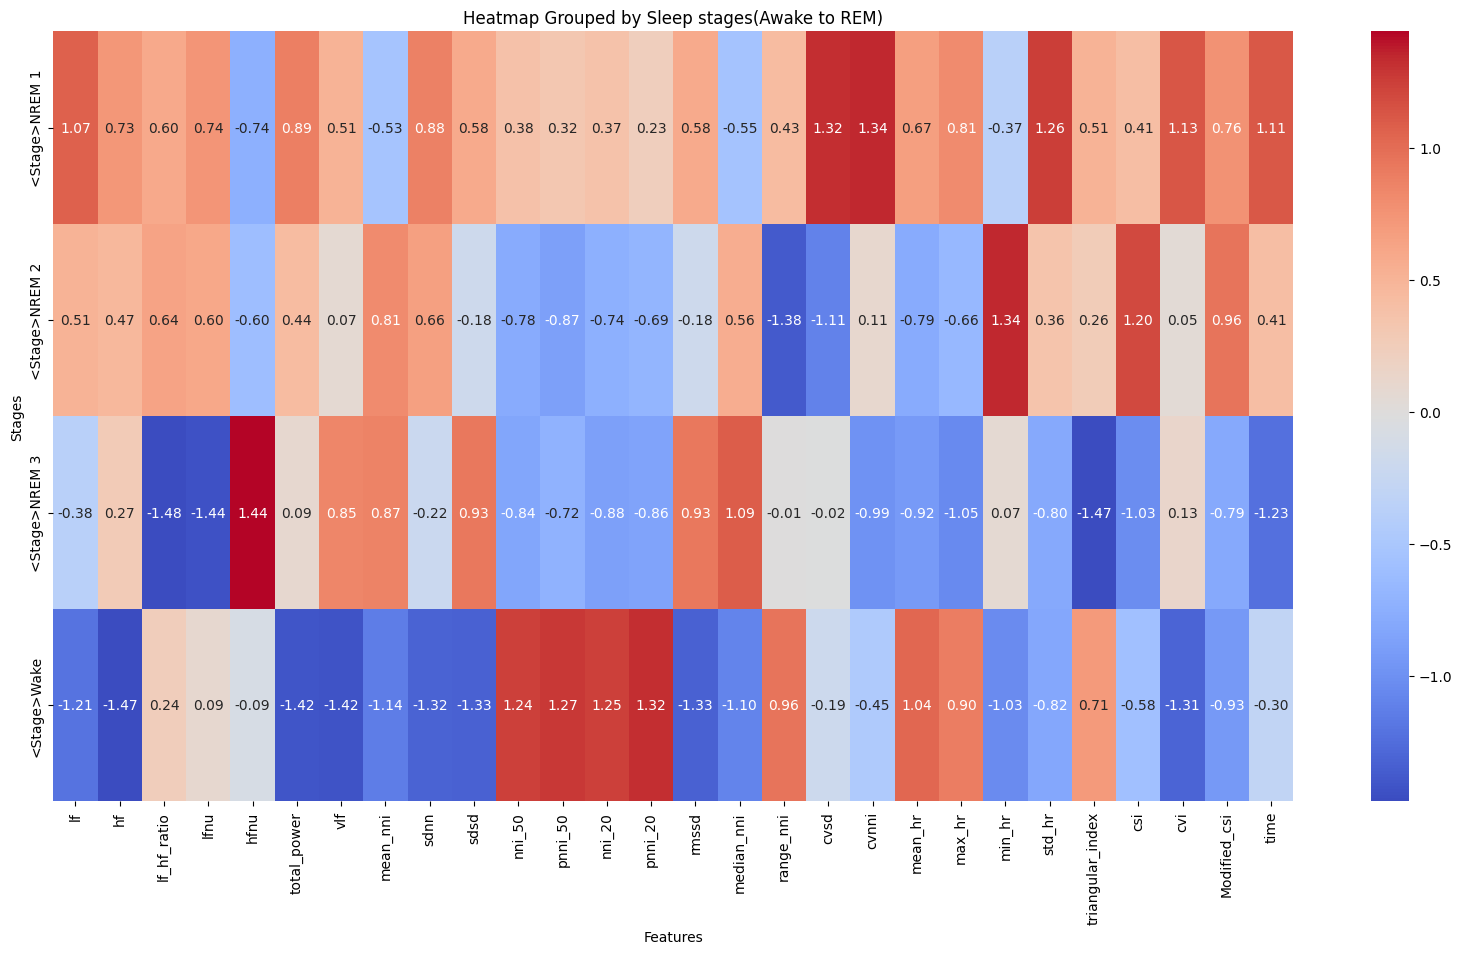

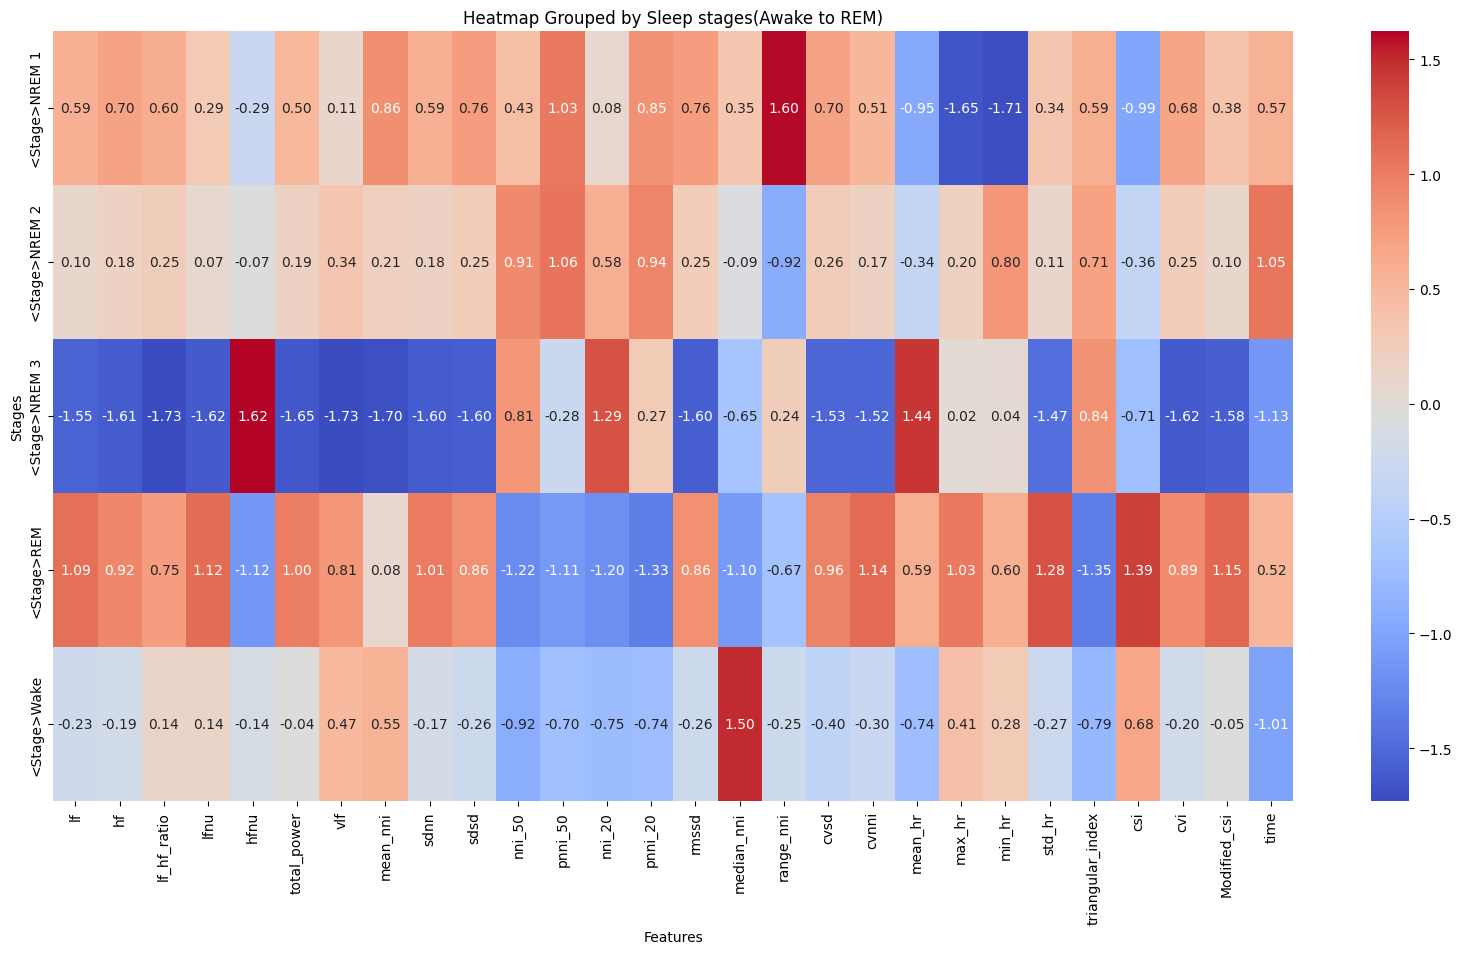

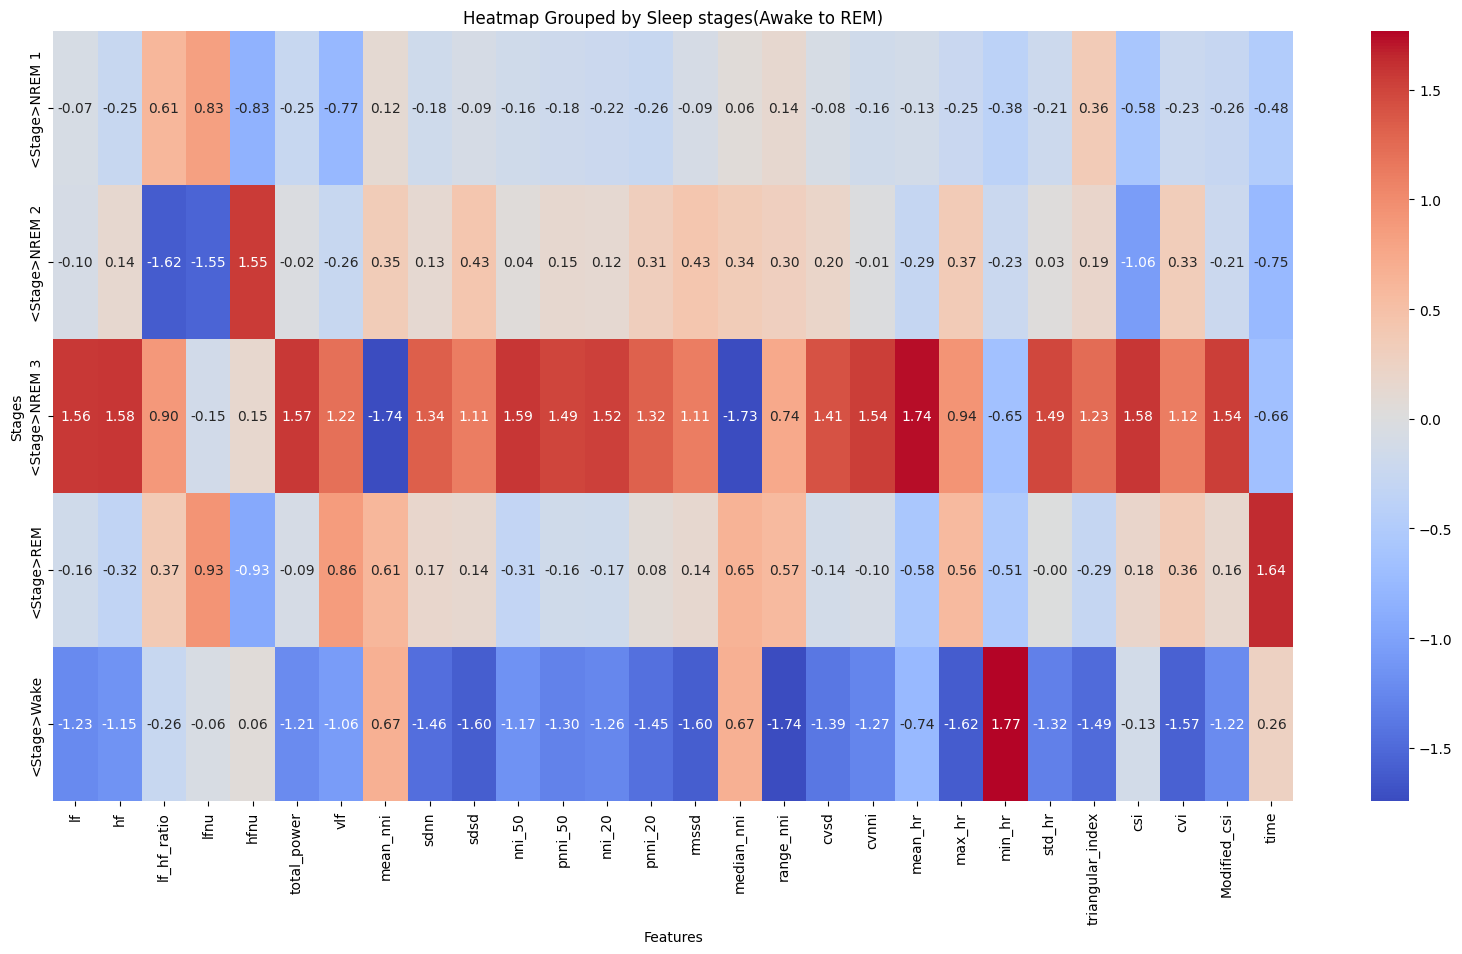

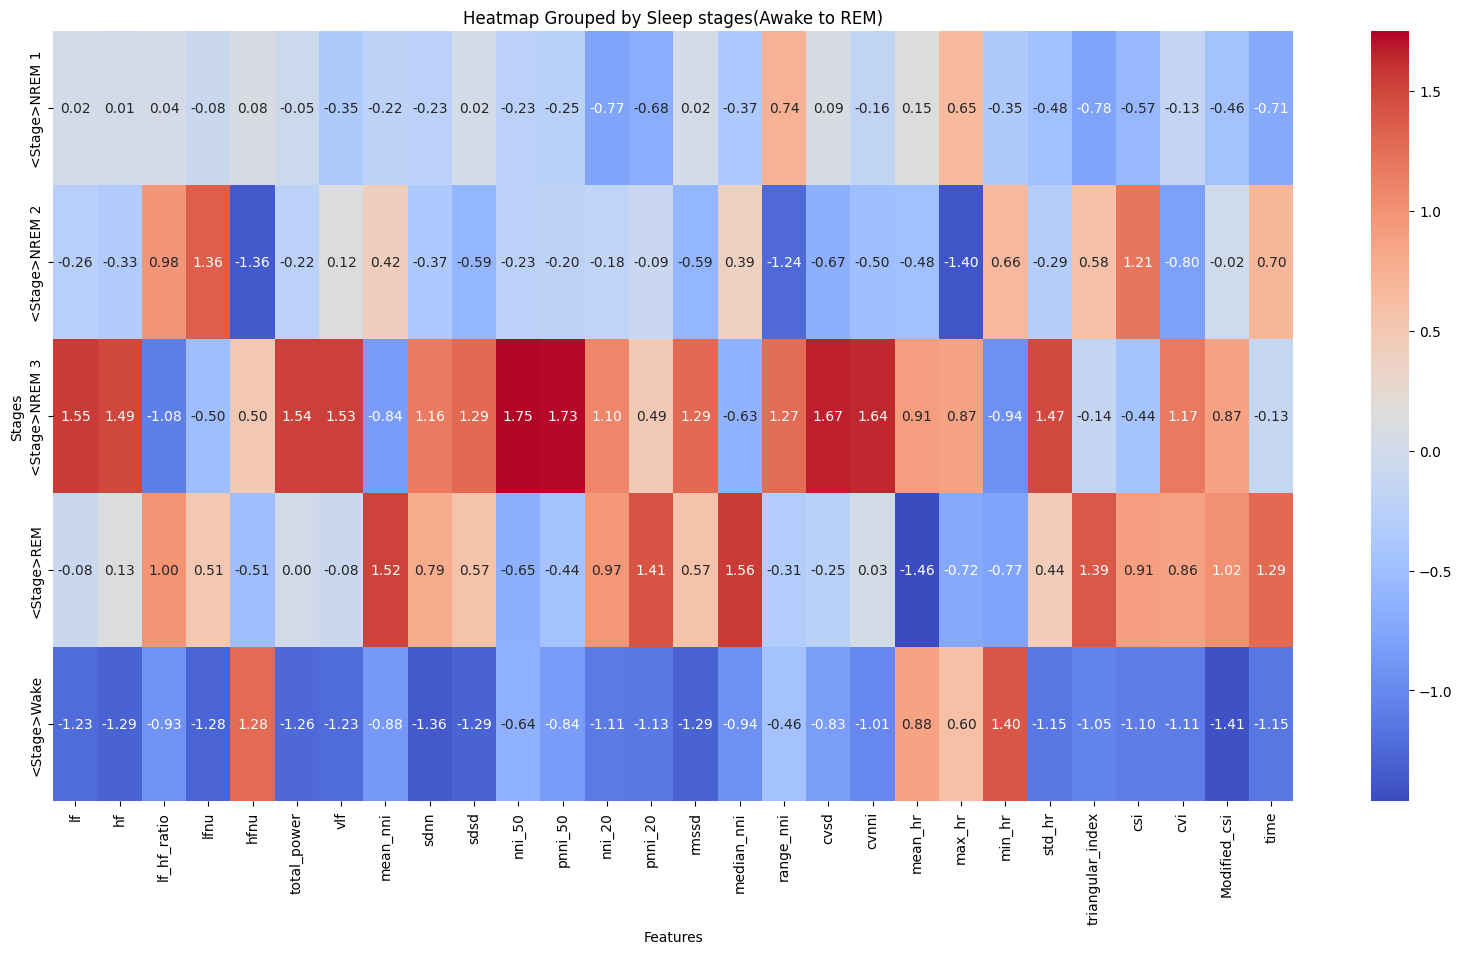

: 

In [43]:
for fl in os.listdir('./labels&feature/'):
   
    df = pd.read_parquet('./labels&feature/'+fl, engine='pyarrow')
    ma = df[['z']].copy()
    ma.index = pd.to_datetime(df['Unnamed: 0']).astype(np.int64)
    ma = ma.dropna()
    fs = 1e-09**-1/np.median(np.diff(ma.index.values.astype(np.int64)))
    cwt_se = do_cwt(ma)
    merged_pks = bandpass_filt(cwt_se,1/0.05,fs,'lowpass')
    merged_pks = signal.find_peaks(merged_pks,height=2e-7,distance=400)
    rr_itv = np.diff(merged_pks[0])
    nn_itv = bbi_filter(rr_itv)
    hrv_fea,ma_it = hrv_generation(nn_itv,df,rr_itv)
    hrv_fea.index = hrv_fea['time']
    stages = df['Stage']
    hrv_df = pd.concat([stages.to_frame(),hrv_fea],axis=1).sort_index().fillna(method='backfill')
    hrv_df_ep = pd.concat([hrv_df,df['Epoch']],axis=1).sort_index().fillna(method='backfill')
    gb_hrv = hrv_df.groupby(by=['Stage']).mean()
    gbhrv = gb_hrv[gb_hrv.index.isin(['<Stage>Wake','<Stage>NREM 1', '<Stage>NREM 2', '<Stage>NREM 3', '<Stage>REM'])]
    hrv_df_ep =  hrv_df_ep.groupby(by = ['Epoch']).median()
    hrv_df_ep.to_parquet('./results/'+fl[:-8]+'_hrv.parquet')

    normalized_data = (gbhrv - gbhrv.mean()) / gbhrv.std()
    plt.figure(figsize=(20, 10))
    sns.heatmap(normalized_data, cmap="coolwarm", annot=True, fmt=".2f")
    plt.title("Heatmap Grouped by Sleep stages(Awake to REM)")
    plt.xlabel("Features",fontsize = 15)
    plt.ylabel("Stages",fontsize = 15)
    plt.savefig('./results/'+fl[:-8]+'_hrvhm.png')


### Testing

In [6]:
stages = df['Stage']

In [11]:
stages.index = df['Unnamed: 0']

RangeIndex(start=0, stop=27405863, step=1)

In [ ]:
stages.index = stages.index.astype(np.int64)

In [ ]:
stages.to_frame()

In [17]:
hrv_df.iloc[121608]

lf                          NaN
hf                          NaN
lf_hf_ratio                 NaN
lfnu                        NaN
hfnu                        NaN
total_power                 NaN
vlf                         NaN
mean_nni                    NaN
sdnn                        NaN
sdsd                        NaN
nni_50                      NaN
pnni_50                     NaN
nni_20                      NaN
pnni_20                     NaN
rmssd                       NaN
median_nni                  NaN
range_nni                   NaN
cvsd                        NaN
cvnni                       NaN
mean_hr                     NaN
max_hr                      NaN
min_hr                      NaN
std_hr                      NaN
triangular_index            NaN
tinn                       None
csi                         NaN
cvi                         NaN
Modified_csi                NaN
time                        NaN
Stage               <Stage>Wake
Name: 121389, dtype: object

In [23]:
hrv_df = pd.concat([stages.to_frame(),hrv_fea],axis=1).sort_index().fillna(method='backfill')


In [22]:
hrv_df = hrv_df.fillna(method='backfill')

In [ ]:
hrv_df.fillna()

In [ ]:
for fl in os.listdir(./re)

In [7]:
hrv_fea.index = hrv_fea['time']
hrv_df = pd.concat([hrv_fea,df['Stage']],join="inner",axis=1)
gb_hrv = hrv_df.groupby(by=['Stage']).mean()
gbhrv = gb_hrv[1:]
hrv_df.to_csv('./results/hrv_yd001.csv')

C:\Users\13103\AppData\Local\Temp\ipykernel_40292\1124519728.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()


In [20]:
hrv_df = pd.concat([hrv_fea,df['Stage']],join="inner",axis=1)

In [8]:
gb_hrv = hrv_df.groupby(by=['Stage']).mean()

C:\Users\13103\AppData\Local\Temp\ipykernel_40292\1250848688.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gb_hrv = hrv_df.groupby(by=['Stage']).mean()


In [30]:
hrv_fea.to_csv('./results/hrv_yd001.csv')

In [23]:
gbhrv = gb_hrv[1:]

In [4]:
data = pd.read_csv('./results/hrv_yd001.csv')
gb_hrv = data.groupby(by=['Stage']).mean()
gb_hrv = gb_hrv[1:]

In [17]:
normalized_data = (gbhrv - gbhrv.mean()) / gbhrv.std()

In [13]:
normalized_data = gbhrv / gbhrv.max()

In [ ]:
fl = 'yd004.parquet'
df = pd.read_parquet('./labels&feature/'+fl, engine='pyarrow')
ma = df[['z']].copy()
ma.index = pd.to_datetime(df['Unnamed: 0']).astype(np.int64)
ma = ma.dropna()
fs = 1e-09**-1/np.median(np.diff(ma.index.values.astype(np.int64)))
cwt_se = do_cwt(ma)
merged_pks = bandpass_filt(cwt_se,1/0.05,fs,'lowpass')
merged_pks = signal.find_peaks(merged_pks,height=2e-7,distance=400)
rr_itv = np.diff(merged_pks[0])
nn_itv = bbi_filter(rr_itv)
hrv_fea,ma_it = hrv_generation(nn_itv,df,rr_itv)
hrv_fea.index = hrv_fea['time']
hrv_df = pd.concat([stages.to_frame(),hrv_fea],axis=1).sort_index().fillna(method='backfill') 
gb_hrv = hrv_df.groupby(by=['Stage']).mean()
gbhrv = gb_hrv[1:]
hrv_df.to_csv('./results/'+fl[:-4]+'_hrv.csv')

normalized_data = (gbhrv - gbhrv.mean()) / gbhrv.std()
plt.figure(figsize=(40, 20))
sns.heatmap(normalized_data, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Heatmap Grouped by Sleep stages(Awake to REM)")
plt.xlabel("Features")
plt.ylabel("Stages")
plt.savefig('./results/'+fl[:-4]+'_hrvhm.png')